In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch
import torch as th
import torch.nn as nn
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns
import tikzplotlib as tikz
from scipy import ndimage

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *
# from utilities import mask_boundary_points
# from utilities import get_invariants
# from utilities import get_tensor_functions
# from torchToFoam import writesymmtensor

# standard datatype
dtype = torch.double

In [2]:
def time():
    return datetime.datetime.now().strftime("%y-%m-%d_%H-%M")

In [3]:
# def trace(tensor):
#     return (tensor[:,0,0] + tensor[:,1,1] + tensor[:,2,2])

In [4]:
def filterField(inputData, std, filter_spatial='Gaussian'):
    """
    Filter a field (e.g. predicted b_ij) spatially using a gaussian or median filter
    """
    if len(inputData.shape) == 4:
        outputData = np.zeros(inputData.shape)
        for i1 in range(inputData.shape[0]):
            for i2 in range(inputData.shape[1]):
                if filter_spatial == 'Gaussian':
                    outputData[i1,i2,:,:] = ndimage.gaussian_filter(inputData[i1,i2,:,:], 
                              std, order=0, output=None, mode='nearest', cval=0.0, truncate=10.0)
                elif filter_spatial == 'Median':
                    outputData[i1,i2,:,:] = ndimage.median_filter(inputData[i1,i2,:,:], 
                              size=std, mode='nearest')
    
    else: #TODO: other input shapes
        pass

    return outputData

In [5]:
# set path to models and initialise arrays
# model_path = '../storage/models/periodic_hills/no_t_norm/ling/model.pt'
model_path = '../storage/models/kaandorp_data/ph_cdc/20000dp_1000ep_100bs_2-5e-5lr/model.pt'

model = th.load(model_path)
_ = model.eval()  # mandatory, see torch.load doc

In [6]:
# read in tensor data
# pred_path = '/home/leonriccius/OpenFOAM/leonriccius-v2006/run/periodic_hills/2d-mesh/700_kEpsilon'
# pred_path = '/home/leonriccius/OpenFOAM/leonriccius-v2006/run/periodic_hills/2d-mesh/700_kEpsilon/'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/training_data/curved_backstep/rans/13700'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/training_data/curved_backstep/rans/13700'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/training_data/periodic_hills/rans/700'
# pred_path = '/home/leonriccius/Documents/Fluid_Data/training_data/conv_div_channel/rans/7900'
pred_path = '/home/leonriccius/Desktop/CurvedBackwardFacingStep/Re13700_kOmega_150_ml'

rans_time = max([int(entry) for entry in os.listdir(pred_path) if entry.isnumeric()])
rans_time = '3000'

rs = th.load(os.sep.join([pred_path, rans_time, 'RS-torch.th']))
s = th.load(os.sep.join([pred_path, rans_time, 'S-torch.th']))
r = th.load(os.sep.join([pred_path, rans_time, 'R-torch.th']))
epsilon0 = th.load(os.sep.join([pred_path, rans_time, 'epsilon-torch.th']))
k0 = th.load(os.sep.join([pred_path, rans_time, 'k-torch.th']))
# cellCenters = th.tensor(th.load(os.sep.join([pred_path, rans_time, 'grid-torch.th'])))
cellCenters = th.load(os.sep.join([pred_path, rans_time, 'grid-torch.th'])).clone().detach()

# expand k
k = k0.unsqueeze(0).unsqueeze(0).expand(3,3,k0.size()[0])
k = k.permute(2, 0, 1)

# expand epsilon
epsilon = epsilon0.unsqueeze(0).unsqueeze(0).expand(3,3,epsilon0.size()[0])
epsilon = epsilon.permute(2, 0, 1)

# get b_rans
b_rans = barymap.anisotropy(rs, k0)

# normalize S and R
s_hat = k/epsilon*s
r_hat = k/epsilon*r

# cap S and R
s_hat = cap_tensor(s_hat, cap=6.)
r_hat = cap_tensor(r_hat, cap=6.)

inv = get_invariants(s_hat, r_hat)
inv_mean_std = mean_std_scaling(inv)
inv_sigmoid = sigmoid_scaling(inv)
t = get_tensor_functions(s_hat, r_hat)
t_zero_trace = enforce_zero_trace(t.reshape(-1,10,3,3))
b_pred,_ = model(inv_mean_std, t_zero_trace.reshape(-1,10,9))
b_pred = b_pred.reshape(-1,3,3).detach()

# dns data
# path_dns = '/home/leonriccius/Documents/Fluid_Data/training_data/periodic_hills/tensordata/700'
path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata/CurvedBackwardFacingStep/13700'
# rs_dns = th.load(os.sep.join([path_dns, 'RS-torch.th']))
# k0_dns = th.load(os.sep.join([path_dns, 'k-torch.th']))
# b_dns = barymap.anisotropy(rs_dns, k0_dns)
b_dns = th.load(os.sep.join([path_dns, 'b_dns-torch.th']))
# cellCenters_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))

enforcing 0 trace ...


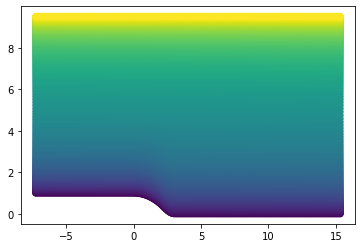

In [7]:
linear=np.linspace(0,1,cellCenters.shape[0])
fig, ax = plt.subplots()
ax.scatter(cellCenters[:,0], cellCenters[:,1], c=linear)

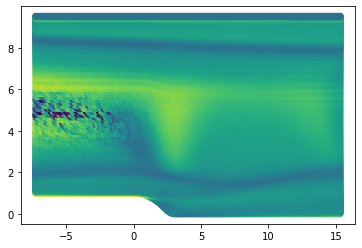

In [8]:
b_dns[th.isnan(b_dns[:,0,0])] = th.zeros(3,3, dtype=float)
fig, ax = plt.subplots()
ax.scatter(cellCenters[:,0], cellCenters[:,1], c=b_dns[:,0,0])

In [9]:
# 

In [10]:
b_real = b_pred.clone()

for i in range(5):
    b_real = enforce_realizability(b_real)

Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True
Violation of condition 1: False
Violation of condition 2: True


In [11]:
print('max b:       {}'.format(th.max(b_pred[:,0,0])))
print('max b_real:  {}'.format(th.mean(b_real[:,0,0])))

max b:       1.8346176432014798
max b_real:  0.18440141807567537


In [45]:
# filter b_pred
nx, ny = 140, 150
b_pred_reshaped = b_pred.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
b_pred_filt = th.from_numpy(filterField(b_pred_reshaped, std=1)).reshape(3,3,-1).permute(2,0,1)
print(th.max(b_pred_filt))

# filter b_real
b_real_reshaped = b_real.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
b_real_filt_1 = th.from_numpy(filterField(b_real_reshaped, std=1)).reshape(3,3,-1).permute(2,0,1)
b_real_filt_2 = th.from_numpy(filterField(b_real_reshaped, std=2)).reshape(3,3,-1).permute(2,0,1)
print(th.max(b_real_filt))

tensor(1.7340, dtype=torch.float64)
tensor(0.5330, dtype=torch.float64)


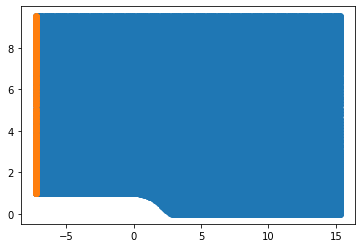

In [46]:
cells_res = cellCenters.reshape(ny,nx,3)
cell_slice = cells_res[:,0]
fig, ax = plt.subplots()
ax.scatter(cellCenters[:,0], cellCenters[:,1])
ax.scatter(cell_slice[:,0], cell_slice[:,1])

In [47]:
# take values from cells closest to inflow boundary as boundary field
# this works as grid is structured
b_boundary = b_pred_filt.reshape(ny,nx,3,3)[:,0]
b_boundary.shape

torch.Size([150, 3, 3])

In [48]:
# boundary list from curved backward facing step
b_list = [('topWall', 'fixedValue_uniform'),
          ('bottomWall', 'fixedValue_uniform'),
          ('inlet', 'fixedValue_nonuniform', b_boundary),
          ('outlet', 'zeroGradient'),
          ('frontAndBack', 'empty')]

rans_time = '3000'

In [49]:
# dd_case_path = '/home/leonriccius/OpenFOAM/leonriccius-v2006/run/converging_diverging_channel/7900_ml'
dd_case_path = pred_path  # '/home/leonriccius/Desktop/Re2800_kOmega_140_dns/'

In [50]:
# writesymmtensor(b_real_filt, os.sep.join([dd_case_path, rans_time, 'b_ml']), b_list)
# writesymmtensor(b_dns, os.sep.join(['/home/leonriccius/Desktop', 'b_dd_jupyter']), b_list)

-7.2587857 15.318786
-7.166047866344453 15.298635668754578


Text(-12.0, 4.0, 'DNS')

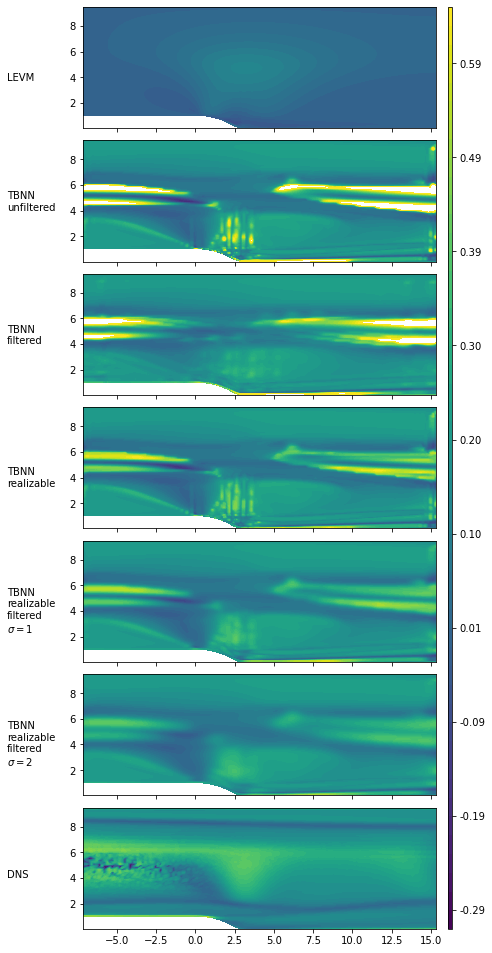

In [77]:
nrows = 7
ncols = 1
s = 1.5

idx = [0,0]

# nx, ny = 140, 100
b_pred_reshaped = b_pred.reshape(nx,ny,3,3).permute(2,3,0,1).detach().numpy()
b_pred_filt = th.from_numpy(filterField(b_pred_reshaped, std=1)).reshape(3,3,-1).permute(2,0,1)

ref = 15
gamma = 0.995
x_min, x_max = np.min(cellCenters[:,0].numpy()), np.max(cellCenters[:,0].numpy())
x_mean = 0.5*(x_max - x_min)
x_min_neu = x_mean - gamma*(x_mean - x_min)
x_max_neu = x_mean - gamma*(x_mean - x_max)

y_min, y_max = np.min(cellCenters[:,1].numpy()), np.max(cellCenters[:,1].numpy())
y_mean = 0.5*(y_max - y_min)
y_min_neu = y_mean - gamma*(y_mean - y_min)
y_max_neu = y_mean - gamma*(y_mean - y_max)

print(x_min, x_max)
print(x_min_neu, x_max_neu)
x_min, x_max = x_min_neu, x_max_neu
y_min, y_max = y_min_neu, y_max_neu
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))
grid_y_shifted = cbfs_interp(grid_x)*(y_max - grid_y)/y_max + grid_y
# grid_y_shifted = grid_y

grid_b_rans = griddata(cellCenters[:,0:2], b_rans.numpy()[:,idx[0],idx[1]], (grid_x, grid_y_shifted), method = 'linear') #, fill_value=0.)
grid_b_pred = griddata(cellCenters[:,0:2], b_pred.numpy()[:,idx[0],idx[1]], (grid_x, grid_y_shifted), method = 'linear')
grid_b_pred_filt = griddata(cellCenters[:,0:2], b_pred_filt.numpy()[:,idx[0],idx[1]], (grid_x, grid_y_shifted), method = 'linear')
grid_b_real = griddata(cellCenters[:,0:2], b_real.numpy()[:,idx[0],idx[1]], (grid_x, grid_y_shifted), method = 'linear')
grid_b_real_filt_1 = griddata(cellCenters[:,0:2], b_real_filt_1.numpy()[:,idx[0],idx[1]], (grid_x, grid_y_shifted), method = 'linear')
grid_b_real_filt_2 = griddata(cellCenters[:,0:2], b_real_filt_2.numpy()[:,idx[0],idx[1]], (grid_x, grid_y_shifted), method = 'linear')
grid_b_dns = griddata(cellCenters[:,0:2], b_dns.numpy()[:,idx[0],idx[1]], (grid_x, grid_y_shifted), method = 'linear')

# get min an max of (b_pred, b_test) for colormap
# tmp = th.cat((b_rans[:,idx[0],idx[1]], b_pred[:,idx[0],idx[1]], b_dns[:,idx[0],idx[1]])).detach().numpy()
# tmp = th.cat((grid_b_rans, grid_b_real, grid_b_dns)).detach().numpy()
tmp = np.vstack((grid_b_rans, grid_b_real, grid_b_dns))
b_min = np.min(tmp)
b_max = np.max(tmp)
levels = np.linspace(b_min, b_max, 50)

# # create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)

b_rans_plot = ax[0].contourf(grid_x, grid_y_shifted, grid_b_rans, levels = levels)
b_pred_plot = ax[1].contourf(grid_x, grid_y_shifted, grid_b_pred, levels = levels)
b_pred_filt_plot = ax[2].contourf(grid_x, grid_y_shifted, grid_b_pred_filt, levels = levels)
b_real_plot = ax[3].contourf(grid_x, grid_y_shifted, grid_b_real, levels = levels)
b_real_filt_1_plot = ax[4].contourf(grid_x, grid_y_shifted, grid_b_real_filt_1, levels = levels)
b_real_filt_2_plot = ax[5].contourf(grid_x, grid_y_shifted, grid_b_real_filt_2, levels = levels)
b_dns_plot = ax[6].contourf(grid_x, grid_y_shifted, grid_b_dns, levels = levels)

fig.colorbar(b_pred_filt_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)
# fig.colorbar(b_dd_plot, ax=ax[0], aspect=15*ncols*nrows, format='%.2f', pad=0.0)
# fig.colorbar(b_dns_plot, ax=ax[1], aspect=15*ncols*nrows, format='%.2f', pad=0.0)

x_off = - 12.
y_off = 4.

ax[0].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left', va='center')
ax[1].text(x_off,y_off, r'TBNN' '\n' r'unfiltered', fontsize='medium', ha='left')
ax[2].text(x_off,y_off, r'TBNN' '\n' r'filtered', fontsize='medium', ha='left')
ax[3].text(x_off,y_off, r'TBNN' '\n' r'realizable', fontsize='medium', ha='left', va='center')
ax[4].text(x_off,y_off, r'TBNN' '\n' r'realizable' '\n' 'filtered' '\n' r'$\sigma = 1$', fontsize='medium', ha='left', va='center')
ax[5].text(x_off,y_off, r'TBNN' '\n' r'realizable' '\n' 'filtered' '\n' r'$\sigma = 2$', fontsize='medium', ha='left', va='center')
ax[6].text(x_off,y_off, r'DNS', fontsize='medium', ha='left')

# save fig
# fig_name = os.sep.join([fig_path, 'griddata.pdf'])
# plt.savefig(fig_name, format='pdf')

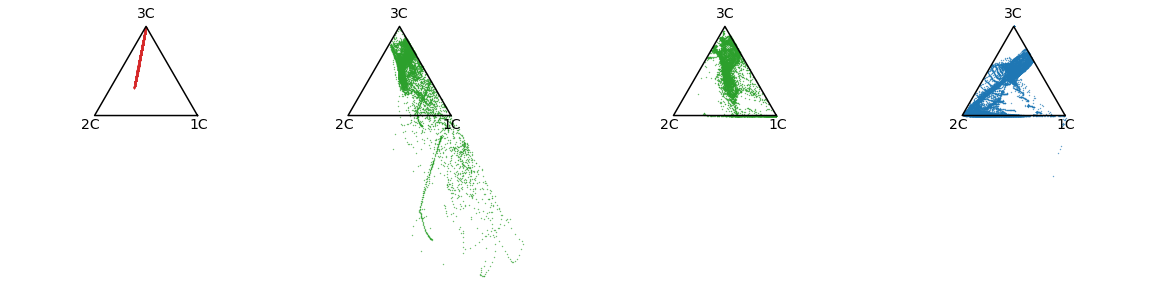

In [76]:
fig, ax = plt.subplots(1,4, figsize=(16,4), sharey=True, constrained_layout=True)

ax[0].axis('equal')
ax[0].axis('off')
ax[1].axis('equal')
ax[1].axis('off')
ax[2].axis('equal')
ax[2].axis('off')
ax[3].axis('equal')
ax[3].axis('off')

barm_rans = BarMap()
# barm_rans.load_from_variable(b_rans[index], cellCenters[index][:,0:2])
barm_rans.load_from_variable(b_rans, cellCenters[:,0:2])
barm_rans.calculate_barycentric_coordinates()
barm_rans.plot_triangle(ax[0])
barm_rans.plot_data_points(ax[0], color=sns.color_palette()[3])

barm_pred = BarMap()
barm_pred.load_from_variable(b_pred_filt.detach().numpy(), cellCenters[:,0:2])
barm_pred.calculate_barycentric_coordinates()
barm_pred.plot_triangle(ax[1])
barm_pred.plot_data_points(ax[1], color=sns.color_palette()[2])

barm_pred = BarMap()
barm_pred.load_from_variable(b_real.detach().numpy(), cellCenters[:,0:2])
barm_pred.calculate_barycentric_coordinates()
barm_pred.plot_triangle(ax[2])
barm_pred.plot_data_points(ax[2], color=sns.color_palette()[2])

barm_dns = BarMap()
# barm_dns.load_from_path(path_dns)
barm_dns.load_from_variable(b_dns, cellCenters[:,0:2])
barm_dns.calculate_barycentric_coordinates()
barm_dns.plot_triangle(ax[3])
barm_dns.plot_data_points(ax[3], color=sns.color_palette()[0])

for axs in ax.flat:
        axs.text(1.1, -0.02, '1C', fontsize=14,
            horizontalalignment='right', verticalalignment='top')
        axs.text(-0.13, -0.02, '2C', fontsize=14,
            horizontalalignment='left', verticalalignment='top')
        axs.text(0.50, 0.92, '3C', fontsize=14,
            horizontalalignment='center', verticalalignment='bottom')
        
# save figure
fig_path = '/home/leonriccius/OneDrive/Dokumente/Uni/Masterthesis/abstract'
fig_name = time() + 'barmap_conv.svg'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='svg')

In [ ]:
fig, ax = plt.subplots()
barm_pred.plot_triangle(ax)
barm_pred.plot_data_points(ax)
ax.axis('equal')
# plt.xlim([0,1])
# plt.ylim([0,1])

In [ ]:
# b_raw = th.rand(5,3,3) - 0.5
# b1 = 0.5 * (b_raw + b_raw.transpose(1,2))
# b_trace = b1[:,0,0] + b1[:,1,1] + b1[:,2,2]
# tensor = b1 - 1./3. * th.eye(3).unsqueeze(0) * b_trace.unsqueeze(1).unsqueeze(2)
# print(tensor, tensor.shape)

In [ ]:
# b_test = b.clone()
# b_test_real = enforce_realizability(b_test)

In [ ]:
tensor = b_pred.clone()
tensor_2 = tensor.clone()

In [ ]:
print(tensor[:2])

In [ ]:
eigval, eigvec = th.symeig(tensor, eigenvectors=True)
print(eigval)
eigval_orig = eigval.clone()

In [ ]:
# tensor = enforce_realizability(tensor)
eigval, eigvec = th.symeig(tensor, eigenvectors=True)
labels = (eigval[:,2] < (3*th.abs(eigval[:,1]) - eigval[:,1])*.5).unsqueeze(1)
eigval *= labels*((3. * th.abs(eigval[:,1]) - eigval[:,1]) / (2.*eigval[:,2])).unsqueeze(1) + ~labels
print('Violation of condition 1:      {}'.format(th.max(labels)))

small = 0.005
labels = (eigval[:,2] > 1./3. - eigval[:,1]).unsqueeze(1)
eigval *= labels*((1./3. - eigval[:,1]) / (eigval[:,2]) - small).unsqueeze(1) + ~labels
print('Violation of condition 2:      {}'.format(th.max(labels)))
print('Index of violation:\n', th.where(labels == True)[0][0:5])
print('Eigenvalues of those tensors:\n', th.symeig(tensor[th.where(labels == True)[0]])[0][0:5])
tensor = eigvec.matmul(th.diag_embed(eigval).matmul(eigvec.transpose(1,2)))

tensor_2 = enforce_realizability(tensor_2, small)
th.max(tensor - tensor_2)

In [ ]:
cellCenters[th.where(labels == True)[0]]#
fig, ax = plt.subplots()
ax.scatter(cellCenters[:,0], cellCenters[:,1])
ax.scatter(cellCenters[th.where(labels == True)[0],0], cellCenters[th.where(labels == True)[0],1])

In [ ]:
# print(b_pred[th.where(labels == True)[0]])

In [ ]:
barm_corrected = BarMap()
barm_corrected.load_from_variable(tensor.detach(), cellCenters[:,0:2])
barm_corrected.calculate_barycentric_coordinates()

barm_corrected_2 = BarMap()
barm_corrected_2.load_from_variable(tensor_2.detach(), cellCenters[:,0:2])
barm_corrected_2.calculate_barycentric_coordinates()

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
ax1.axis('equal')
ax2.axis('equal')
barm_corrected.plot_triangle(ax1)
barm_corrected.plot_data_points(ax1)
barm_corrected_2.plot_triangle(ax2)
barm_corrected_2.plot_data_points(ax2)

In [ ]:
def barycentric_coefficients(eigval):
    coords = th.empty_like(eigval)
    coords[:,0] = eigval[:,2] - eigval[:,1]
    coords[:,1] = 2.*(eigval[:,1] - eigval[:,0])
    coords[:,2] = 3.*eigval[:,0]+1.
    return coords

In [ ]:
coords = barycentric_coefficients(eigval)

In [ ]:
coords

In [ ]:
th.min(coords)

## Plotting routines

In [ ]:
fig_path = '/home/leonriccius/Desktop'

x,y = cellCenters[:,0].numpy(), cellCenters[:,1].numpy()
triang = tri.Triangulation(x, y)
triang.set_mask(y[triang.triangles].mean(axis=1) < cdc_interp(x[triang.triangles].mean(axis=1)))

nrows = 2
ncols = 1
s = 1.5

idx = [2,2]

# get min an max of (b_pred, b_test) for colormap
tmp = th.cat((b_pred[:,idx[0],idx[1]], b_dns[:,idx[0],idx[1]])).detach().numpy()
b_min = np.min(tmp)
b_max = np.max(tmp)
levels = np.linspace(b_min, b_max, 10)

# create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)

b_dd_plot = ax[0].tricontourf(triang, b_pred[:,idx[0],idx[1]].detach().numpy(), levels=levels)
b_dns_plot = ax[1].tricontourf(triang, b_dns[:,idx[0],idx[1]].detach().numpy(), levels=levels)

# fig.colorbar(b_dd_plot, ax=ax.flat, aspect=15*ncols*nrows, format='%.2f', pad=0.0)
fig.colorbar(b_dd_plot, ax=ax[0], aspect=15*ncols*nrows, format='%.2f', pad=0.0)
fig.colorbar(b_dns_plot, ax=ax[1], aspect=15*ncols*nrows, format='%.2f', pad=0.0)

# save fig
fig_name = os.sep.join([fig_path, 'triangulated.pdf'])
plt.savefig(fig_name, format='pdf')

In [ ]:
fig_path = '/home/leonriccius/Desktop'
nrows = 5
ncols = 2
s = 1.5

# create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.5*ncols, s*1.25*nrows), sharex=True, sharey=True,
                       constrained_layout=True)

for i in range(5):
    unscaled = ax[i,0].tricontourf(cellCenters[:,0], cellCenters[:,1], inv[:,i])
    mean_std = ax[i,1].tricontourf(cellCenters[:,0], cellCenters[:,1], inv_mean_std[:,i])
    
    cbar_unscaled = fig.colorbar(unscaled, ax=ax[i,0], format='%.1f', pad=0.0)
    cbar_mean_std = fig.colorbar(mean_std, ax=ax[i,1], format='%.1f', pad=0.0)
    
    cbar_unscaled.ax.locator_params(nbins=5)
    cbar_mean_std.ax.locator_params(nbins=5)
    
# save figure
fig_name = time() + '_phill_scaling_options'
# plt.savefig(os.sep.join([fig_path, fig_name + '.pdf']), format='pdf')
# tikz.save(os.sep.join([fig_path, fig_name + '.pgf']))
# fig.suptitle(r'trained on ' + model_names[i], y=1.01, fontsize=14)